In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm

In [2]:
#NLP Imports
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.layers import Dense, Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional, Dropout, Input

# Model Creation Imports
from tensorflow.keras.models import Sequential, Model

# Computer Vision Imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import DenseNet201

# Model Learning & Losses Imports
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Warning & Visualization Imports
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")

### Load Datasets

In [3]:
image_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/Image_Captioning/Images'
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Datasets/Image_Captioning/captions.txt")

In [4]:
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

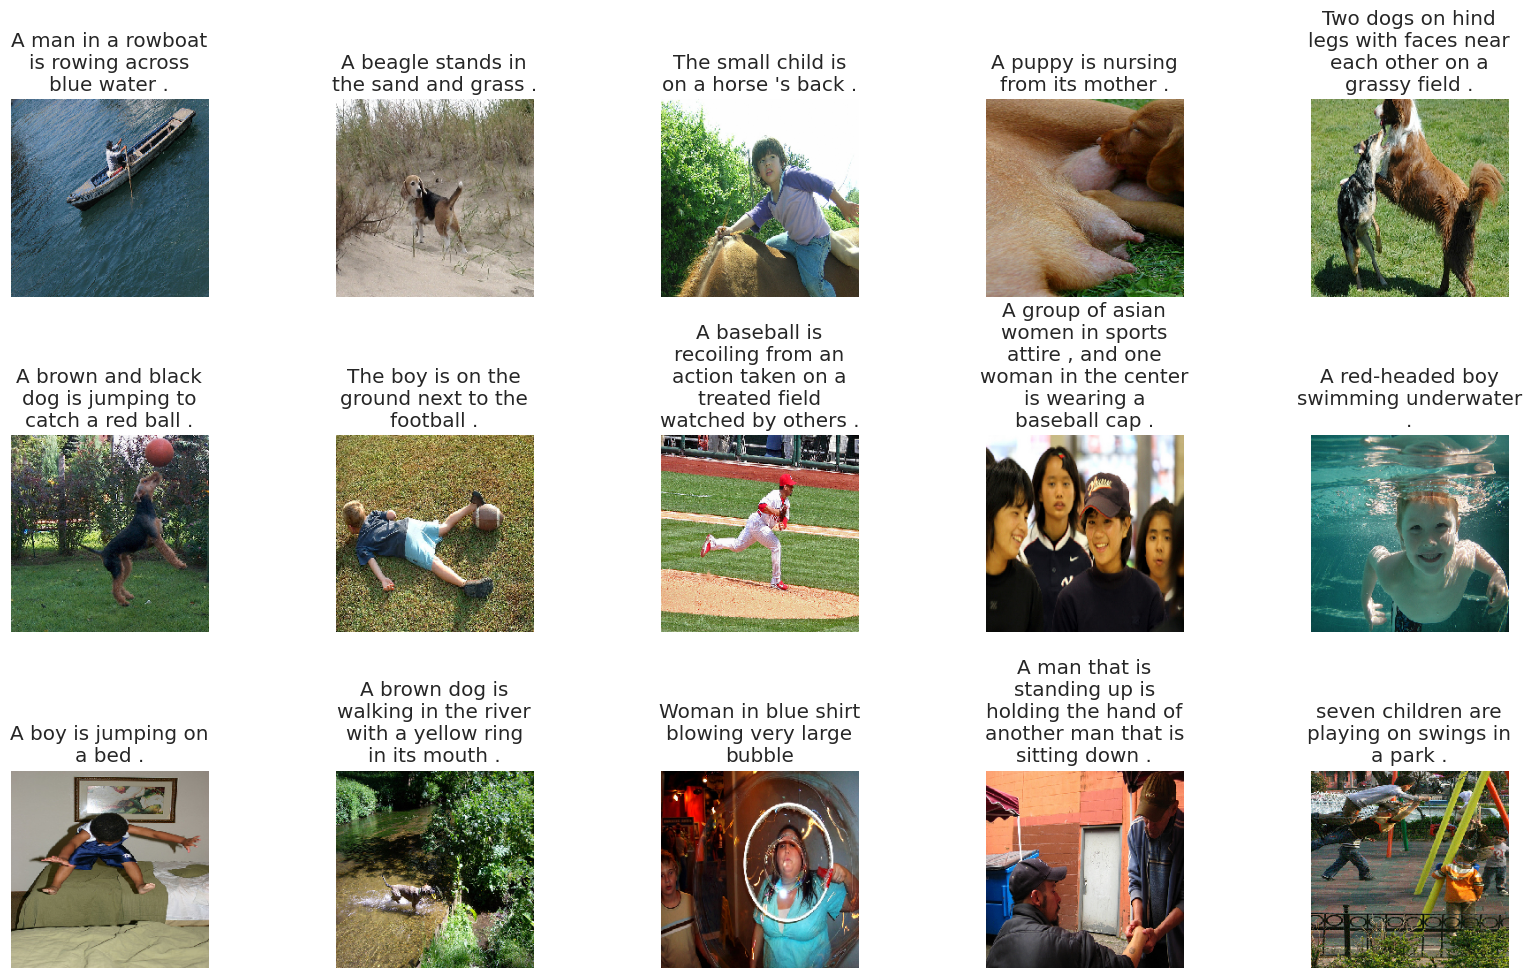

In [5]:
def readImage(path, img_size=224):
  img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
  img = img_to_array(img)
  img = img/255.

  return img

def display_images(temp_df):
  temp_df = temp_df.reset_index(drop=True)
  plt.figure(figsize=(20, 20))
  n = 0
  for i in range(15):
    n+=1
    plt.subplot(5,5,n)
    plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
    image = readImage(f"/content/drive/MyDrive/Colab Notebooks/Datasets/Image_Captioning/Images/{temp_df.image[i]}")
    plt.imshow(image)
    plt.title("\n".join(wrap(temp_df.caption[i], 20)))
    plt.axis('off')

display_images(data.sample(15))

## Text Preprocessing

In [6]:
def text_preprocessing(data):
  data['caption'] = data['caption'].apply(lambda x: x.lower())
  data['caption'] = data['caption'].apply(lambda x:x.replace("[^A-Za-z]", ""))
  data['caption'] = data['caption'].apply(lambda x:x.replace("\s+", " "))
  data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
  data['caption'] = data['caption'].apply(lambda x:"<start> " + x + " <end>")

  return data

data = text_preprocessing(data)

captions = data['caption'].tolist()
captions[:5]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

## Tokenization

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)

vocab_size = len(tokenizer.word_index) + 1    #8483

max_length = max([len(caption.split()) for caption in captions])    #34

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
val = data[data['image'].isin(val_images)]

train.reset_index(inplace=True, drop=True)
val.reset_index(inplace=True, drop=True)

tokenizer.texts_to_sequences([captions[2]])[0]

[2, 39, 18, 118, 63, 195, 2426, 1]

## Image Feature Extraction

In [8]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
tf.test.gpu_device_name()

Num GPUs Available: 1


'/device:GPU:0'

In [10]:
model = DenseNet201()

fe = Model(inputs = model.input, outputs = model.layers[-2].output)

img_size=224
features = {}

batch_images = []
batch_names = []
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0
    batch_images.append(img)
    batch_names.append(image)

    if len(batch_images) == 64:  # batch size
        batch_images = np.array(batch_images)
        with tf.device('/GPU:0'):
          features_batch = fe.predict(batch_images, verbose=0)
        for i, fname in enumerate(batch_names):
            features[fname] = features_batch[i]
        batch_images, batch_names = [], []

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


100%|██████████| 8091/8091 [45:45<00:00,  2.95it/s]


## Data Generation

In [23]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            if image in self.features: # Check if image feature exists
                feature = self.features[image]

                captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
                for caption in captions:
                    seq = self.tokenizer.texts_to_sequences([caption])[0]

                    for i in range(1,len(seq)):
                        in_seq, out_seq = seq[:i], seq[i]
                        in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                        out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                        X1.append(feature)
                        X2.append(in_seq)
                        y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y


train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=val,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [24]:
train_generator[0]

((array([[7.8687910e-05, 7.3524052e-04, 1.1395991e-03, ..., 5.6523389e-01,
          2.2903745e-01, 6.9639736e-01],
         [7.8687910e-05, 7.3524052e-04, 1.1395991e-03, ..., 5.6523389e-01,
          2.2903745e-01, 6.9639736e-01],
         [7.8687910e-05, 7.3524052e-04, 1.1395991e-03, ..., 5.6523389e-01,
          2.2903745e-01, 6.9639736e-01],
         ...,
         [1.9476042e-04, 7.0213038e-04, 1.4947486e-03, ..., 2.7233737e-02,
          5.5759603e-01, 3.8916522e-01],
         [1.9476042e-04, 7.0213038e-04, 1.4947486e-03, ..., 2.7233737e-02,
          5.5759603e-01, 3.8916522e-01],
         [1.9476042e-04, 7.0213038e-04, 1.4947486e-03, ..., 2.7233737e-02,
          5.5759603e-01, 3.8916522e-01]], dtype=float32),
  array([[  0,   0,   0, ...,   0,   0,   2],
         [  0,   0,   0, ...,   0,   2,  42],
         [  0,   0,   0, ...,   2,  42,   3],
         ...,
         [  0,   0,   0, ...,  10,  76,  49],
         [  0,   0,   0, ...,  76,  49,   4],
         [  0,   0,   0, ...,

## Model Building

In [25]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1,256))(img_features)

sentence_features = Embedding(vocab_size, 256)(input2)

merged = concatenate([img_features_reshaped, sentence_features], axis=1)
sentence_features = LSTM(256)(merged)

x = Dropout(0.5)(sentence_features)
# Add a Dense layer to match the shape of sentence_features before adding
img_features_dense = Dense(256, activation='relu')(img_features)
x = add([x, img_features_dense])
x = Dense(128, activation='relu')(x)
x= Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

#Define the model checkpoint
model_name = 'caption_model.keras'
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode = "min",
    save_best_only = True,
    save_weights_only=False,
    verbose = 1
)

earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta = 0,
                              patience = 5,
                              verbose = 1,
                              restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                             patience=3,
                                             factor = 0.2,
                                             min_lr=1e-8,
                                             verbose=1)

history = caption_model.fit(
    train_generator,
    epochs=100,
    validation_data = validation_generator,
    callbacks = [checkpoint,  earlystopping, learning_rate_reduction],
    verbose = 1
)

Epoch 1/100
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 5.6915
Epoch 1: val_loss improved from inf to 4.31011, saving model to caption_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 85s 153ms/step - loss: 5.6903 - val_loss: 4.3101 - learning_rate: 0.0010
Epoch 2/100
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 4.3540
Epoch 2: val_loss improved from 4.31011 to 3.99540, saving model to caption_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 82s 153ms/step - loss: 4.3539 - val_loss: 3.9954 - learning_rate: 0.0010
Epoch 3/100
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 4.0287
Epoch 3: val_loss improved from 3.99540 to 3.81268, saving model to caption_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 82s 152ms/step - loss: 4.0287 - val_loss: 3.8127 - learning_rate: 0.0010
Epoch 4/100
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 3.8299
Epoch 4: val_loss improved from 3.81268 to 3.72172, saving model to caption_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 83s 154ms/step - loss: 3.8299 - val_l

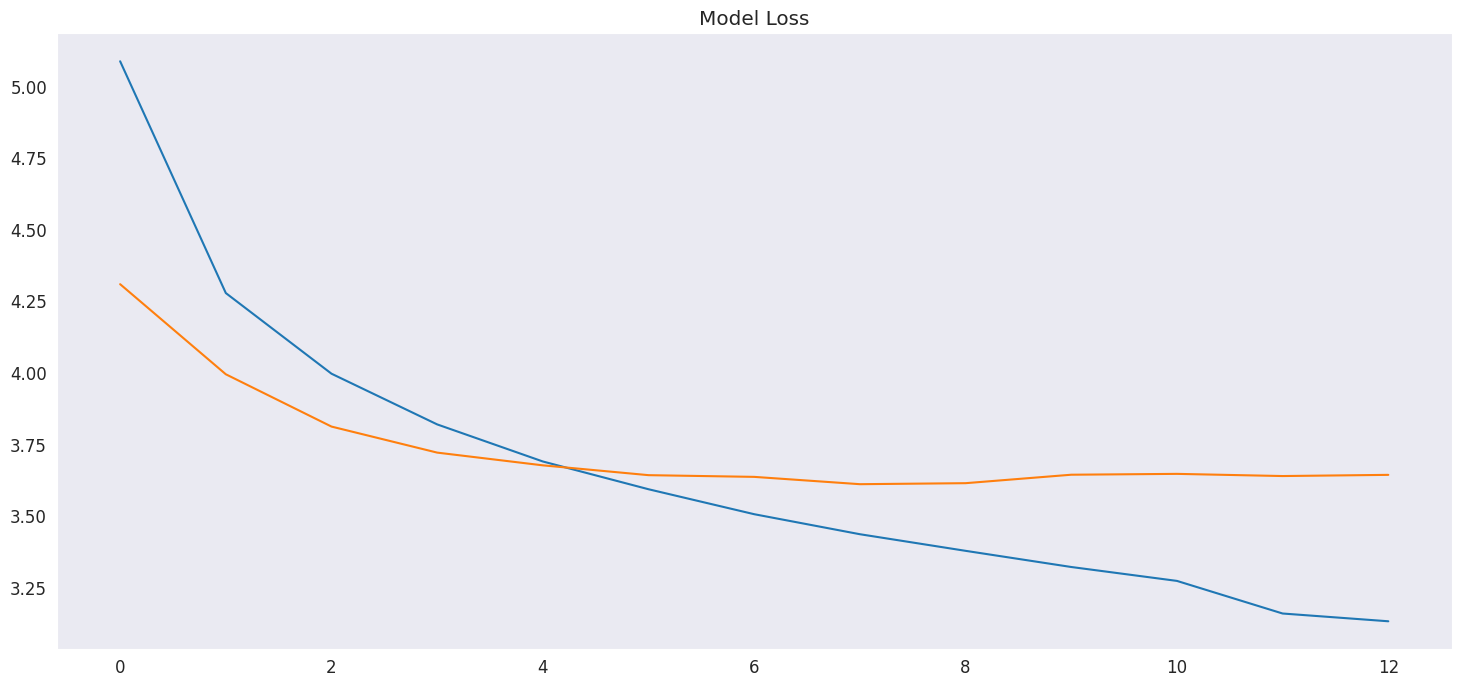

In [26]:
plt.figure(figsize=(18, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.show()

## Caption Generation Utility Function

In [27]:
import pickle

#Save the tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

#Save the feature extractor model
fe.save("feature_extractor.keras")

In [44]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle

# load save files
model_path = "caption_model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"


def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34, img_size=224):
    # Load the trained models and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)
    image_features = feature_extractor.predict(img, verbose=0)  # Extract image features

    # Generate the caption
    in_text = "<start>"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        if word == "end":
            break
        in_text += " " + word

    caption = in_text.replace("<start>", "").replace("end", "").strip()

    # Display the image with the generated caption
    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()

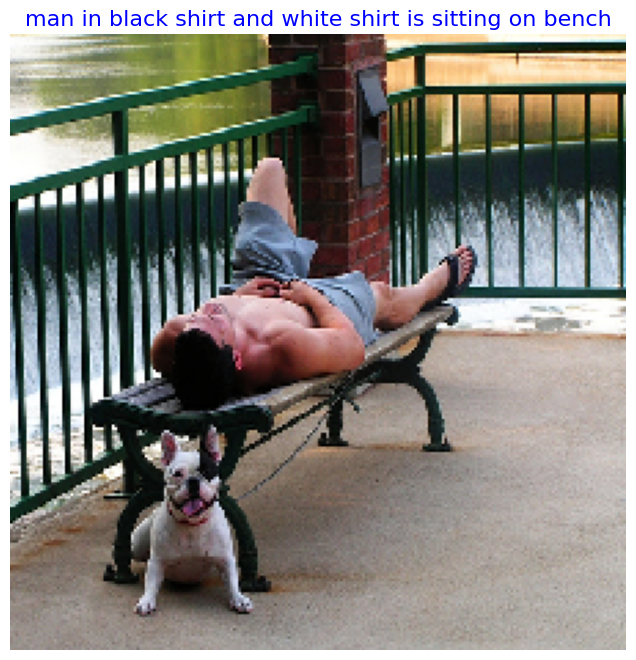

In [45]:
image_path = "/content/drive/MyDrive/Colab Notebooks/Datasets/Image_Captioning/Images/1003163366_44323f5815.jpg"
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

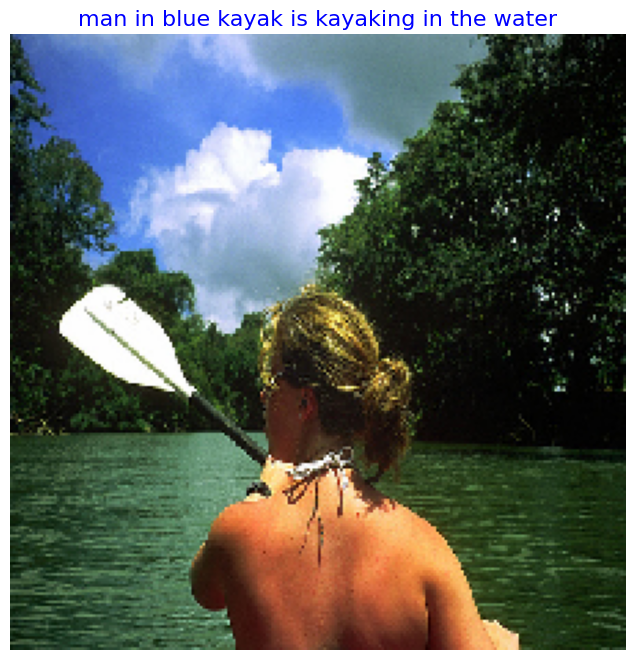

In [46]:
image_path = "/content/drive/MyDrive/Colab Notebooks/Datasets/Image_Captioning/Images/105342180_4d4a40b47f.jpg"
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

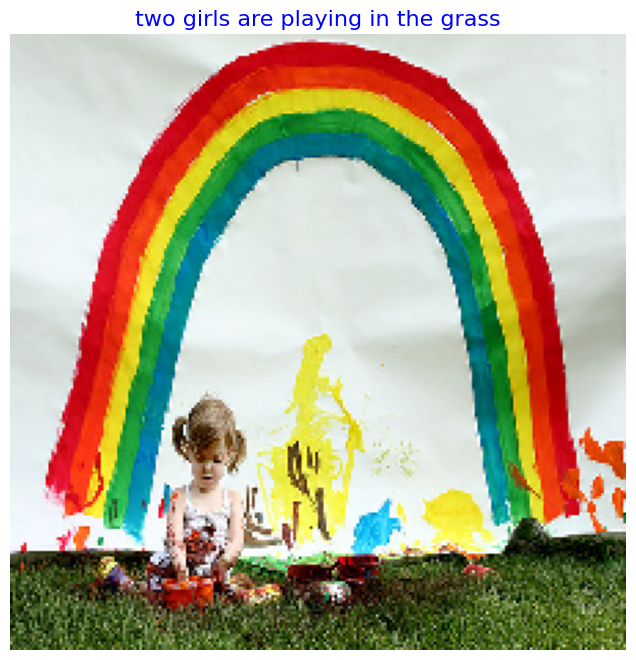

In [47]:
image_path = "/content/drive/MyDrive/Colab Notebooks/Datasets/Image_Captioning/Images/1002674143_1b742ab4b8.jpg"
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

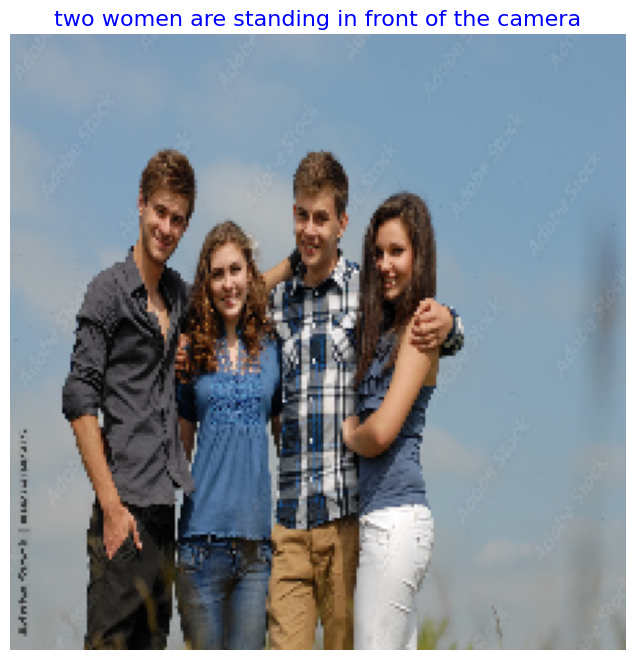

In [49]:
image_path = "/content/img3.jpg"
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)